In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor, ExtraTreesRegressor
from catboost import CatBoostRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import optuna

In [2]:
# Устанавливаем глобальное начальное состояние генератора случайных чисел
np.random.seed(42)

In [ ]:
df = pd.read_csv('data/df_si_iqr.csv')

In [5]:
# Разделяем данные
X = df.drop(columns=['SI'])
y = df['SI']

In [6]:
# Делим исходные данные на тренировочную и тестовую выборки
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2)

Теперь необходимо выбрать оптимальную модель.

Для построения предсказательной модели были рассмотрены следующие алгоритмы:

* XGBRegressor;

* XGBRegressor с функцией потерь Tweedie;

* RandomForestRegressor;

* GradientBoostingRegressor;

* CatBoostRegressor;

* CatBoostRegressor с функцией потерь Tweedie ;

* HistGradientBoostingRegressor;

* ExtraTreesRegressor.

Так как все перечисленные алгоритмы основаны на деревьях решений, они не чувствительны к масштабу признаков и не требуют стандартизации или нормализации входных данных. Кроме того, методы снижения размерности, такие как PCA, также не обязательны, поскольку деревья эффективно справляются с избыточностью и коррелированными признаками.

Таким образом, подготовленные данные были напрямую переданы в модели без предварительной стандартизации или понижения размерности.

In [7]:
models = {
    'XGB': XGBRegressor(),
    'XGB_Tweedie': XGBRegressor(objective='reg:tweedie'),
    'RandomForest': RandomForestRegressor(),
    'GradientBoosting': GradientBoostingRegressor(),
    'CatBoost': CatBoostRegressor(verbose=0),
    'CatBoost_Tweedie': CatBoostRegressor(verbose=0, loss_function='Tweedie:variance_power=1.4'),
    'HistGradientBoostingRegressor': HistGradientBoostingRegressor(),
    'ExtraTreesRegressor': ExtraTreesRegressor()
}

In [8]:
def evaluate_models(models, X_train_full, y_train_full, X_test, y_test):
    results = []

    for name, model in models.items():
        pipeline = Pipeline([
            ('regressor', model)
        ])

        pipeline.fit(X_train_full, y_train_full)
        y_pred = pipeline.predict(X_test)

        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)

        results.append({
            'Model': name,
            'R2': round(r2, 4),
            'RMSE': round(rmse, 4),
            'MAE': round(mae, 4),
            'Tuned': False
        })

    return pd.DataFrame(results)
results_untuned = evaluate_models(models, X_train_full, y_train_full, X_test, y_test)
display(results_untuned)

,Model,R2,RMSE,MAE,Tuned
0,XGB,-0.1277,9.0371,5.8764,False
1,XGB_Tweedie,-0.0228,8.6063,5.0845,False
2,RandomForest,0.0215,8.4181,5.8684,False
3,GradientBoosting,0.1142,8.0092,5.4552,False
4,CatBoost,0.0281,8.3895,5.5789,False
5,CatBoost_Tweedie,0.0735,8.1911,4.9100,False
6,HistGradientBoostingRegressor,0.0250,8.4031,5.5868,False
7,ExtraTreesRegressor,-0.0394,8.6761,5.6291,False


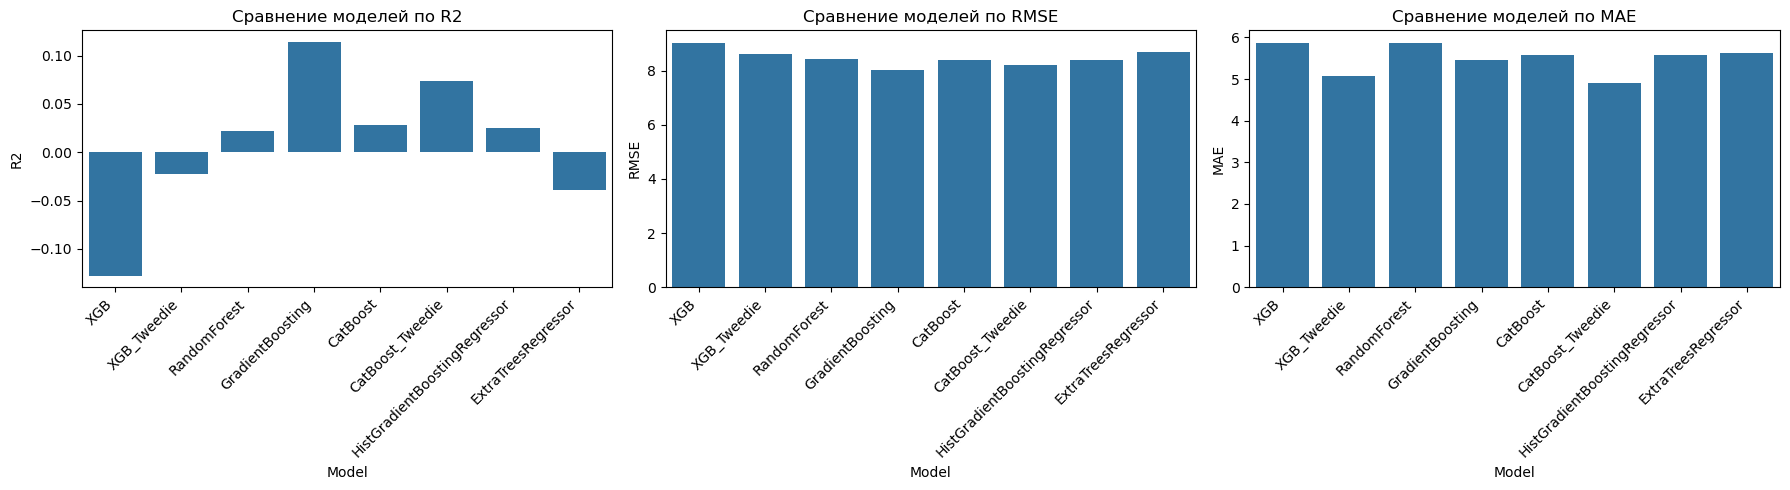

In [ ]:
def plot_metrics_comparison(results_df):
    metrics = ['R2', 'RMSE', 'MAE']
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))

    for i, metric in enumerate(metrics):
        sns.barplot(data=results_df, x='Model', y=metric, ax=axs[i])
        axs[i].set_title(f'Сравнение моделей по {metric}')
        axs[i].set_xticks(range(len(results_df['Model'])))
        axs[i].set_xticklabels(results_df['Model'], rotation=45, ha='right')

    plt.tight_layout()
    plt.show()

plot_metrics_comparison(results_untuned)

In [11]:
def optuna_tuning(models, n_trials=50):
    results = []
    trained_models = {}

    # Фиксируем глобальный сид для NumPy, чтобы train_test_split был детерминирован
    np.random.seed(42)

    # Проходим по всем моделям из переданного словаря
    for model_key, model in models.items():
        # Разбиваем данные на train/validation
        X_train, X_valid, y_train, y_valid = train_test_split(
            X_train_full, y_train_full, test_size=0.2, random_state=42
        )

        # Определяем функцию-цель для Optuna
        def objective(trial):
            # Для каждой модели формируем свой словарь параметров
            if model_key == 'XGB':
                params = {
                    'n_estimators': trial.suggest_int('n_estimators', 50, 500),
                    'max_depth': trial.suggest_int('max_depth', 3, 10),
                    'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
                    'subsample': trial.suggest_float('subsample', 0.5, 1.0),
                    'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
                    'gamma': trial.suggest_float('gamma', 0, 5),
                    'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
                    'random_state': 42
                }
                reg = XGBRegressor(**params)

            elif model_key == 'XGB_Tweedie':
                params = {
                    'n_estimators': trial.suggest_int('n_estimators', 50, 500),
                    'max_depth': trial.suggest_int('max_depth', 3, 10),
                    'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
                    'subsample': trial.suggest_float('subsample', 0.5, 1.0),
                    'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
                    'gamma': trial.suggest_float('gamma', 0, 5),
                    'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
                    'tweedie_variance_power': trial.suggest_float('tweedie_variance_power', 1.1, 1.9),
                    'random_state': 42
                }
                reg = XGBRegressor(**params, objective='reg:tweedie')

            elif model_key == 'RandomForest':
                params = {
                    'n_estimators': trial.suggest_int('n_estimators', 50, 300),
                    'max_depth': trial.suggest_int('max_depth', 3, 20),
                    'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
                    'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
                    'max_features': trial.suggest_categorical('max_features', ['log2', 'sqrt', None]),
                    'random_state': 42
                }
                reg = RandomForestRegressor(**params)

            elif model_key == 'GradientBoosting':
                params = {
                    'n_estimators': trial.suggest_int('n_estimators', 50, 300),
                    'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
                    'max_depth': trial.suggest_int('max_depth', 3, 10),
                    'subsample': trial.suggest_float('subsample', 0.5, 1.0),
                    'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
                    'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
                    'max_features': trial.suggest_categorical('max_features', [None, 'sqrt', 'log2']),
                    'random_state': 42
                }
                reg = GradientBoostingRegressor(**params)

            elif model_key == 'CatBoost':
                params = {
                    'iterations': trial.suggest_int('iterations', 100, 1000),
                    'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
                    'depth': trial.suggest_int('depth', 4, 10),
                    'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
                    'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1),
                    'random_seed': 42
                }
                reg = CatBoostRegressor(**params, verbose=False)

            elif model_key == 'CatBoost_Tweedie':
                # Задаем Tweedie variance_power от 1.1 до 1.9
                variance_power = trial.suggest_float('variance_power', 1.1, 1.9)

                params = {
                    'iterations': trial.suggest_int('iterations', 100, 1000),
                    'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
                    'depth': trial.suggest_int('depth', 4, 10),
                    'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
                    'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1),
                    'random_seed': 42,
                    # Здесь формируем строку loss_function с текущим variance_power
                    'loss_function': f"Tweedie:variance_power={variance_power}"
                }
                reg = CatBoostRegressor(**params, verbose=False)

            elif model_key == 'HistGradientBoostingRegressor':
                params = {
                    'max_iter': trial.suggest_int('max_iter', 50, 300),
                    'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
                    'max_depth': trial.suggest_int('max_depth', 3, 10),
                    'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
                    'l2_regularization': trial.suggest_float('l2_regularization', 0, 1),
                    'random_state': 42
                }
                reg = HistGradientBoostingRegressor(**params)

            elif model_key == 'ExtraTreesRegressor':
                params = {
                    'n_estimators': trial.suggest_int('n_estimators', 50, 300),
                    'max_depth': trial.suggest_int('max_depth', 3, 20),
                    'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
                    'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
                    'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
                    'random_state': 42
                }
                reg = ExtraTreesRegressor(**params)

            # Обучаем на train и проверяем R2 на valid
            reg.fit(X_train, y_train)
            y_pred = reg.predict(X_valid)
            return r2_score(y_valid, y_pred)

        # Запускаем оптимизацию Optuna
        study = optuna.create_study(direction='maximize')
        study.optimize(objective, n_trials=n_trials)

        # Формируем финальную модель с лучшими гиперпараметрами
        best_params = study.best_params

        if model_key == 'XGB':
            final_model = XGBRegressor(**best_params, random_state=42)

        elif model_key == 'XGB_Tweedie':
            final_model = XGBRegressor(**best_params, objective='reg:tweedie', random_state=42)

        elif model_key == 'RandomForest':
            final_model = RandomForestRegressor(**best_params, random_state=42)

        elif model_key == 'GradientBoosting':
            final_model = GradientBoostingRegressor(**best_params, random_state=42)

        elif model_key == 'CatBoost':
            final_model = CatBoostRegressor(**best_params, random_seed=42, verbose=False)

        elif model_key == 'CatBoost_Tweedie':
            # Извлекаем optimal variance_power из best_params
            vp = best_params.pop('variance_power')
            loss_str = f"Tweedie:variance_power={vp}"
            final_model = CatBoostRegressor(**best_params, loss_function=loss_str, random_seed=42, verbose=False)

        elif model_key == 'HistGradientBoostingRegressor':
            final_model = HistGradientBoostingRegressor(**best_params, random_state=42)

        elif model_key == 'ExtraTreesRegressor':
            final_model = ExtraTreesRegressor(**best_params, random_state=42)

        # Обучаем финальную модель на полном тренировочном наборе
        final_model.fit(X_train_full, y_train_full)

        # Сохраняем обученную модель в словарь trained_models
        trained_models[model_key] = final_model

        # Оцениваем финальную модель на тестовом наборе
        y_test_pred = final_model.predict(X_test)
        test_r2 = r2_score(y_test, y_test_pred)
        test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
        test_mae = mean_absolute_error(y_test, y_test_pred)

        # Сохраняем метрики в список results
        results.append({
            'Model': model_key,
            'R2': round(test_r2, 4),
            'RMSE': round(test_rmse, 4),
            'MAE': round(test_mae, 4),
            'Tuned': True
        })

    # Превращаем список результатов в DataFrame
    results_tuned = pd.DataFrame(results)

    # Возвращаем две структуры: DataFrame и словарь обученных моделей
    return results_tuned, trained_models

In [12]:
results_tuned, trained_models = optuna_tuning(models)

[I 2025-06-02 19:41:41,381] A new study created in memory with name: no-name-779540f6-ec43-46d5-9289-bff00860a651
[I 2025-06-02 19:41:42,029] Trial 0 finished with value: 0.06814227889828806 and parameters: {'n_estimators': 487, 'max_depth': 3, 'learning_rate': 0.1975660938743247, 'subsample': 0.9252154790667662, 'colsample_bytree': 0.7481667559713612, 'gamma': 2.1958985882896997, 'min_child_weight': 8}. Best is trial 0 with value: 0.06814227889828806.
[I 2025-06-02 19:41:42,347] Trial 1 finished with value: 0.2028970227590905 and parameters: {'n_estimators': 88, 'max_depth': 7, 'learning_rate': 0.02749670657251045, 'subsample': 0.692132524770082, 'colsample_bytree': 0.8054324086575739, 'gamma': 3.7567905819615084, 'min_child_weight': 6}. Best is trial 1 with value: 0.2028970227590905.
[I 2025-06-02 19:41:43,053] Trial 2 finished with value: 0.06739110483339683 and parameters: {'n_estimators': 440, 'max_depth': 7, 'learning_rate': 0.11155942567461416, 'subsample': 0.8741394179213939, '

In [13]:
results_tuned

,Model,R2,RMSE,MAE,Tuned
0,XGB,0.1407,7.8884,5.5434,True
1,XGB_Tweedie,0.0910,8.1137,5.3519,True
2,RandomForest,0.1305,7.9352,5.7150,True
3,GradientBoosting,0.1502,7.8448,5.4877,True
4,CatBoost,0.0833,8.1479,5.6424,True
5,CatBoost_Tweedie,0.1483,7.8538,5.1547,True
6,HistGradientBoostingRegressor,0.1349,7.9151,5.5755,True
7,ExtraTreesRegressor,0.1162,8.0003,5.6628,True


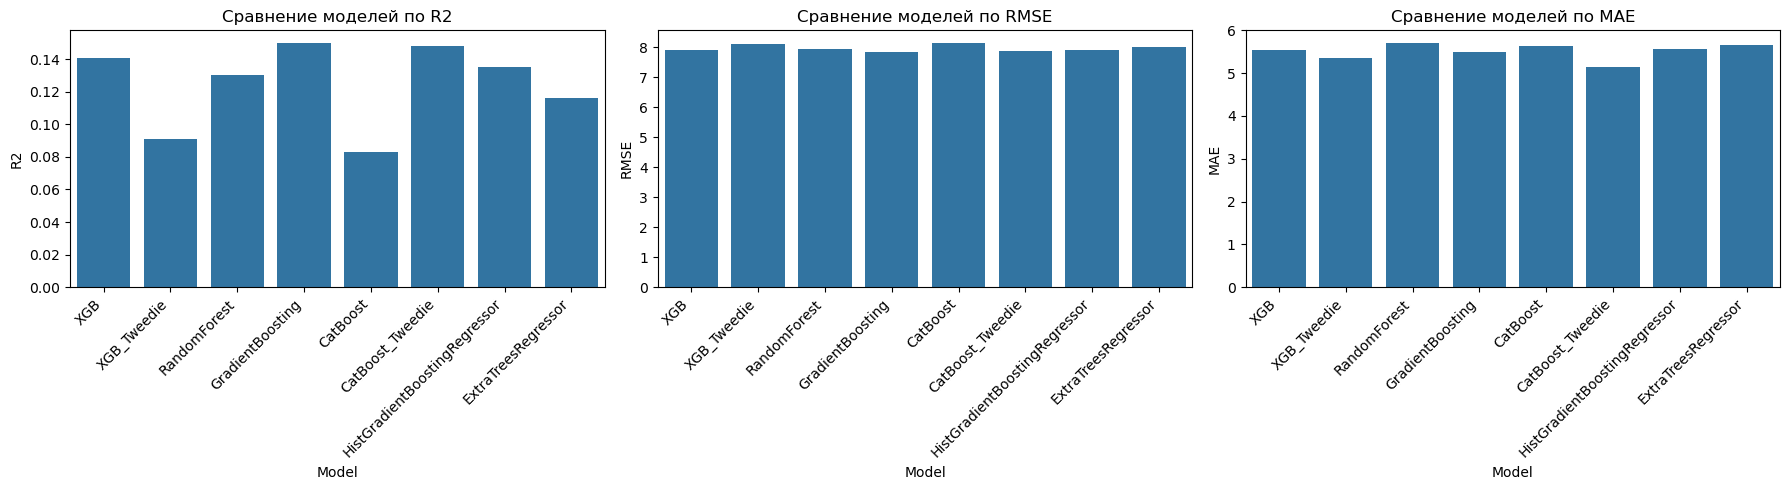

In [14]:
plot_metrics_comparison(results_tuned)

In [ ]:
combined_results = pd.concat([results_untuned, results_tuned], ignore_index=True)
display(combined_results.sort_values(by=["R2"], ascending=False))

,Model,R2,RMSE,MAE,Tuned
11,GradientBoosting,0.1502,7.8448,5.4877,True
13,CatBoost_Tweedie,0.1483,7.8538,5.1547,True
8,XGB,0.1407,7.8884,5.5434,True
14,HistGradientBoostingRegressor,0.1349,7.9151,5.5755,True
10,RandomForest,0.1305,7.9352,5.7150,True
15,ExtraTreesRegressor,0.1162,8.0003,5.6628,True
3,GradientBoosting,0.1142,8.0092,5.4552,False
9,XGB_Tweedie,0.0910,8.1137,5.3519,True
12,CatBoost,0.0833,8.1479,5.6424,True
5,CatBoost_Tweedie,0.0735,8.1911,4.9100,False


<Figure size 1500x500 with 0 Axes>

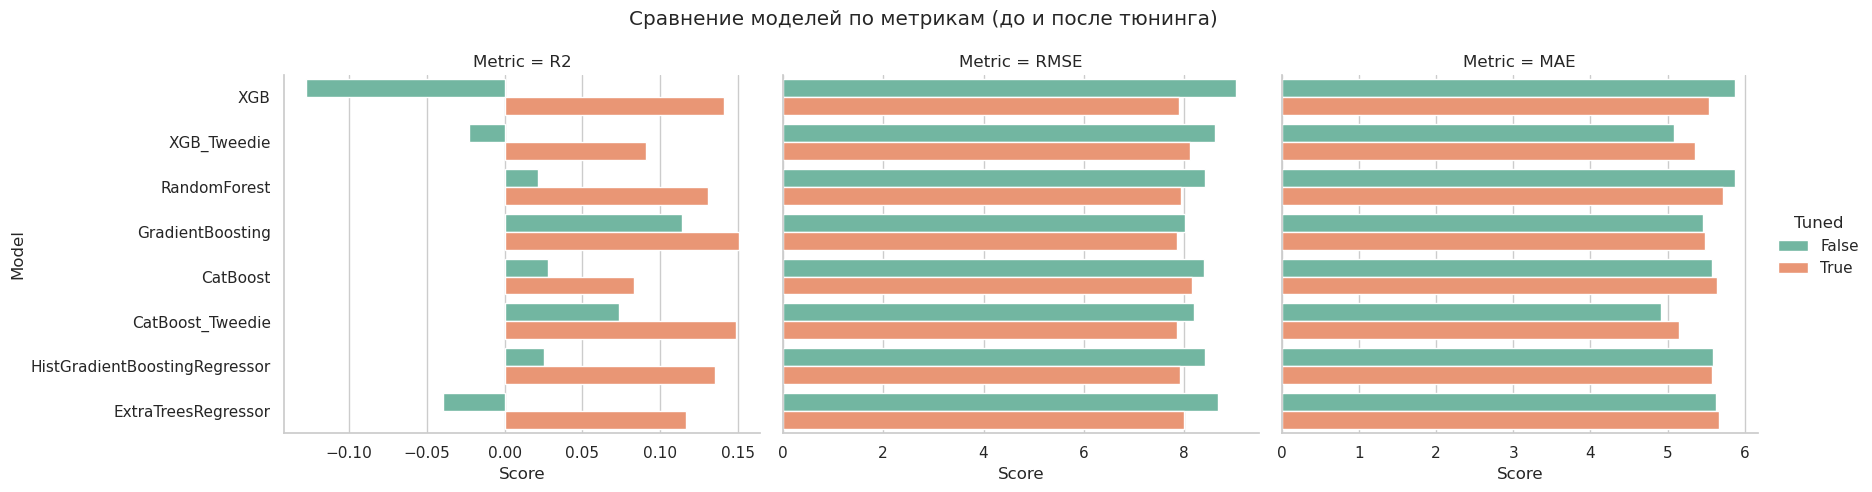

In [16]:
def plot_all_metrics(combined_results):
    melted = combined_results.melt(
        id_vars=["Model", "Tuned"],
        value_vars=["R2", "RMSE", "MAE"],
        var_name="Metric",
        value_name="Score"
    )

    plt.figure(figsize=(15, 5))
    sns.set(style="whitegrid")

    g = sns.catplot(
        data=melted,
        x="Score",
        y="Model",
        hue="Tuned",
        col="Metric",
        kind="bar",
        palette="Set2",
        sharex=False,
        height=5,
        aspect=1.2
    )

    g.fig.subplots_adjust(top=0.85)
    g.fig.suptitle("Сравнение моделей по метрикам (до и после тюнинга)")
    plt.show()
plot_all_metrics(combined_results)